In [32]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings

import numpy as np
import scanpy as sc
import scipy.sparse as sps

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed

import sys
from pathlib import Path
from os.path import join
cur_dir = Path(os.getcwd())
sys.path.append(str(cur_dir.parent.absolute()))

import moco.builder
from moco.builder import ClaireNet
from moco.base_encoder import Encoder, EncoderL2
from moco.config import Config
from moco.dataset_optim import ClaireDataset, print_AnchorInfo
from moco.preprocessing import embPipe

from moco.trainval import load_ckpt, evaluate, train, save_checkpoint, get_args, adjust_learning_rate

import matplotlib.pyplot as plt

In [5]:
from args import Args

configs = Config()

args = Args()

##========================
args.dname = 'Pancreas'    # set data folder name here

args.anchor_schedule = [2]
print_freq = args.print_freq

# set training environ
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

# set logging dir
sane_ps = 'optim_'   
sane_ps += f'knn={args.knn}_alpha={args.alpha}_augSet={args.augment_set}_'   # for construction strategy
sane_ps += f'anc-schedl={args.anchor_schedule}_filter={args.fltr}_yita={args.yita}_'   # for refinment strategy
sane_ps += f'eps={args.epochs}_lr={args.lr}_batch-size={args.batch_size}_'   # training params
sane_ps += f'adjustLr={args.adjustLr}_schedule={args.schedule}'             # training params

log_dir = join(configs.out_root, f'{args.dname}/{sane_ps}')
os.makedirs(log_dir, exist_ok=True)

# Training

In [6]:
ri = 0 # repeated experiment
os.makedirs(join(log_dir, f'weights{ri+1}'), exist_ok=True)     # folder used to save model weights
os.makedirs(join(log_dir, f'results{ri+1}'), exist_ok=True)     # folder to save lossCurve and umap results

# Data loading code
traindir = os.path.join(configs.data_root, args.dname)
train_dataset = ClaireDataset(
    traindir,
    mode='train',
    select_hvg=args.select_hvg,
    scale=False,
    knn=args.knn,
    alpha=args.alpha,
    augment_set=args.augment_set,
    exclude_fn=(args.dname!='MouseCellAtlas'),
    verbose=1
    )
val_dataset = ClaireDataset(
    traindir,
    mode='val',
    select_hvg=args.select_hvg,
    scale=False,
    knn=args.knn,
    alpha=args.alpha,
    verbose=0
    )

assert np.all(train_dataset.gname == val_dataset.gname), 'unmatched gene names'
assert np.all(train_dataset.cname == val_dataset.cname), 'unmatched cell names'
val_dataset.X = train_dataset.X  # eliminate randomness in preprocessing steps
train_steps = train_dataset.n_sample // args.batch_size

val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=args.batch_size, 
        num_workers=args.workers, 
        shuffle=False, 
        drop_last=False)

model = ClaireNet(
    base_encoder=EncoderL2,
    in_dim=train_dataset.n_feature,
    lat_dim=args.lat_dim, 
    block_level=args.block_level,
    args=args
) 

model = model.cuda()

if args.optim=='Adam':
    optimizer = torch.optim.Adam(model.parameters(), args.lr,
                                # momentum=args.momentum,
                                weight_decay=args.weight_decay)
elif args.optim=='SGD':
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

cudnn.benchmark = True

# start training
if not args.skip_training:
    print('==========>Start training<==========')
    loss = []
    for epoch in range(args.start_epoch, args.epochs):
        if args.adjustLr:
            adjust_learning_rate(optimizer, epoch, args)

        if epoch in args.anchor_schedule:
            print(f'================== Anchor schedule {epoch}')
            lat_emb, latl2_emb = evaluate(val_loader, model, args)

            print('filtering anchors')
            train_dataset.filter_anchors(latl2_emb,  
                                        fltr=args.fltr,
                                        yita=args.yita
                                        )


            train_dataset.exclude_sampleWithoutMNN(True)
            train_dataset.getMnnDict()

            if train_dataset.type_label is not None:
                print_AnchorInfo(train_dataset.pairs, train_dataset.batch_label, train_dataset.type_label)


        # train one epoch
        train_dataset.update_pos_nn_info()
        train_loader = torch.utils.data.DataLoader(
                                                    train_dataset, 
                                                    batch_size=args.batch_size, 
                                                    num_workers=args.workers, 
                                                    shuffle=True, 
                                                    drop_last=True)
        lossi = train(train_loader, model, optimizer, epoch, args)
        loss.append(lossi)

        if (epoch+1) % args.save_freq == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                # 'arch': args.arch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, is_best=False, filename=join(log_dir, 'weights{}/checkpoint_{:04d}.pth.tar'.format(ri+1, epoch+1)))

    # fig = plt.plot(loss, label='loss')
    np.save(join(log_dir, f'results{ri+1}/loss.npy'), loss)

The reading cost time 0.3364 secs


... storing 'batch' as categorical
... storing 'celltype_orig' as categorical
... storing 'celltype' as categorical
/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Defined ops:  ['int']
loading anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Pancreas/seuratAnchors.csv
Anchors n=33765, ratio=0.8846
batch
Baron_b1          0.748045
Mutaro_b2         0.991989
Segerstolpe_b3    0.984485
Wang_b4           1.000000
Xin_b5            0.937668
dtype: float64
type
MHC class II    1.000000
acinar          0.737573
alpha           0.910784
beta            0.807893
delta           0.816770
ductal          0.914080
endothelial     0.366782
epsilon         0.821429
gamma           0.963415
macrophage      0.618182
mast            0.843750
mesenchymal     0.990654
schwann         0.769231
stellate        0.657534
t_cell          0.428571
dtype: float64
Number of training samples = 12465
Sample-wise knn ratio=0.9820
The reading cost time 0.0503 secs


... storing 'batch' as categorical
... storing 'celltype_orig' as categorical
... storing 'celltype' as categorical
/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


==========>Start training<==========
Epoch: [0][ 9/48]	Time  0.020 ( 0.067)	Data  0.002 ( 0.047)	Loss 7.4288e+00 (6.5435e+00)
Epoch: [0][19/48]	Time  0.028 ( 0.047)	Data  0.008 ( 0.026)	Loss 7.1998e+00 (6.9152e+00)
Epoch: [0][29/48]	Time  0.022 ( 0.039)	Data  0.003 ( 0.019)	Loss 7.2052e+00 (7.0148e+00)
Epoch: [0][39/48]	Time  0.024 ( 0.035)	Data  0.005 ( 0.015)	Loss 7.1597e+00 (7.0398e+00)
Epoch: [1][ 9/48]	Time  0.022 ( 0.082)	Data  0.002 ( 0.061)	Loss 7.0076e+00 (7.0360e+00)
Epoch: [1][19/48]	Time  0.024 ( 0.054)	Data  0.004 ( 0.033)	Loss 7.0502e+00 (7.0152e+00)
Epoch: [1][29/48]	Time  0.027 ( 0.043)	Data  0.003 ( 0.023)	Loss 6.9640e+00 (6.9985e+00)
Epoch: [1][39/48]	Time  0.029 ( 0.038)	Data  0.004 ( 0.018)	Loss 6.9683e+00 (6.9855e+00)
================== Anchor schedule 2
filtering anchors
Number of training samples = 11820
Anchors n=30573, ratio=0.9475
batch
Baron_b1          0.696114
Mutaro_b2         0.978794
Segerstolpe_b3    0.969911
Wang_b4           0.962801
Xin_b5           

# Inference

=> loaded checkpoint: checkpoint_0010.pth.tar
=> loaded checkpoint: checkpoint_0020.pth.tar
=> loaded checkpoint: checkpoint_0040.pth.tar
=> loaded checkpoint: checkpoint_0080.pth.tar
=====================> 10


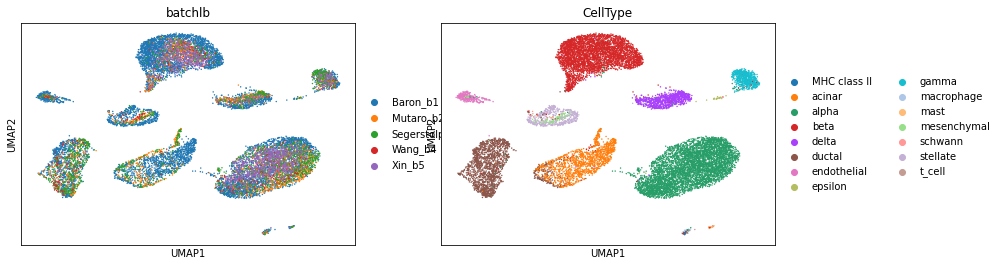

=====================> 20


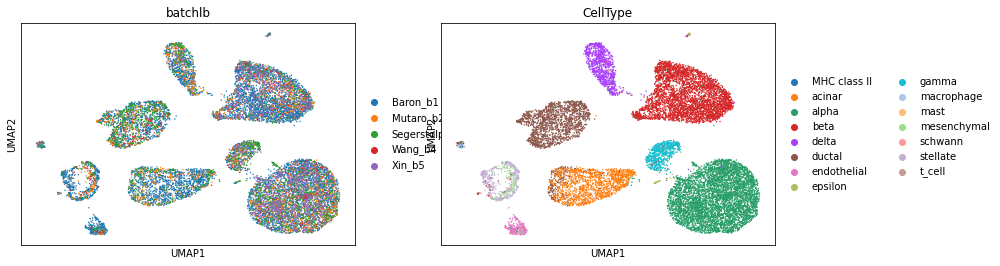

=====================> 40


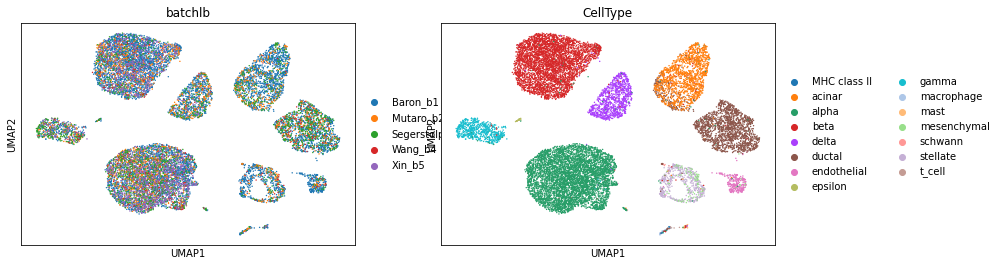

=====================> 80


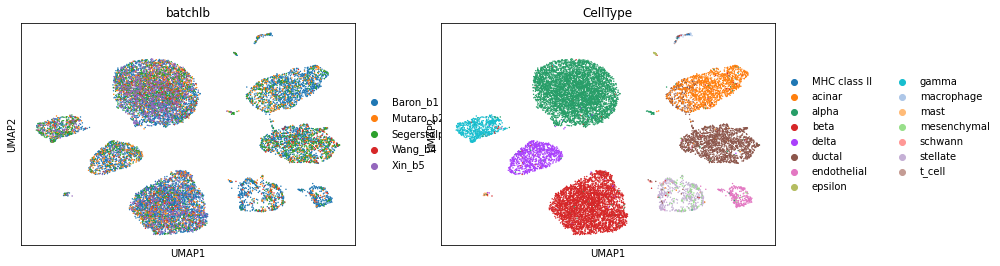

In [13]:
# inference with specified checkpoints
args.visualize_ckpts = list(filter(lambda x: x<=args.epochs, args.visualize_ckpts))

tmp_emb = {}
for idx in args.visualize_ckpts:
    if idx > args.epochs:
        continue
        
    ckpt_dir = join(log_dir, f'weights{ri+1}')
    model = load_ckpt(model, ckpt_dir, idx)
    lat_emb, latl2_emb = evaluate(val_loader, model, args)

    ad_lat = embPipe(latl2_emb, train_dataset.metadata) 
#     ad_lat.write(join(log_dir, f'results{ri+1}/ad_{idx}.h5ad'))

    tmp_emb[idx] = ad_lat 

# saving plot
for i, idx in enumerate(args.visualize_ckpts):
    print(f'=====================> {idx}')

    sc.pl.umap(tmp_emb[idx], color=[configs.batch_key, configs.label_key])


# Clustering

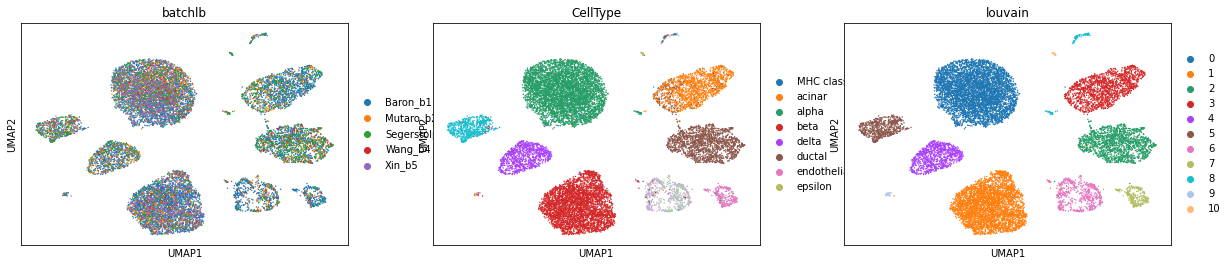

In [21]:
adata_res = tmp_emb[80]

sc.tl.louvain(adata_res, resolution=.5)
sc.pl.umap(adata_res, color=['batchlb', 'CellType', 'louvain'])

In [23]:
# evaluate using ARI
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(adata_res.obs.louvain, adata_res.obs.CellType)  

0.9448902665042345

# Finding DEGs

### 1. First, integrate genes 

In [29]:
from moco.utils import integrate_gene

integrated_gene_matrix = integrate_gene(adata_res.X, train_dataset.X, adata_res.obs, train_dataset.gname, 
                                       scale=False, batch_key='batchlb', label_key='CellType',
                                       knn=10, sigma=20, alpha=0.1)

### 2. Detect DEGs

In [37]:
adata_gene = sc.AnnData(integrated_gene_matrix, obs=adata_res.obs)
adata_gene.var_names = train_dataset.gname

# check whether gene matrix is well integrated 
# sc.pp.scale(adata_gene)
# sc.pp.pca(adata_gene, n_comps=50)
# sc.pp.neighbors(adata_gene, n_neighbors=30)
# sc.tl.umap(adata_gene)

/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


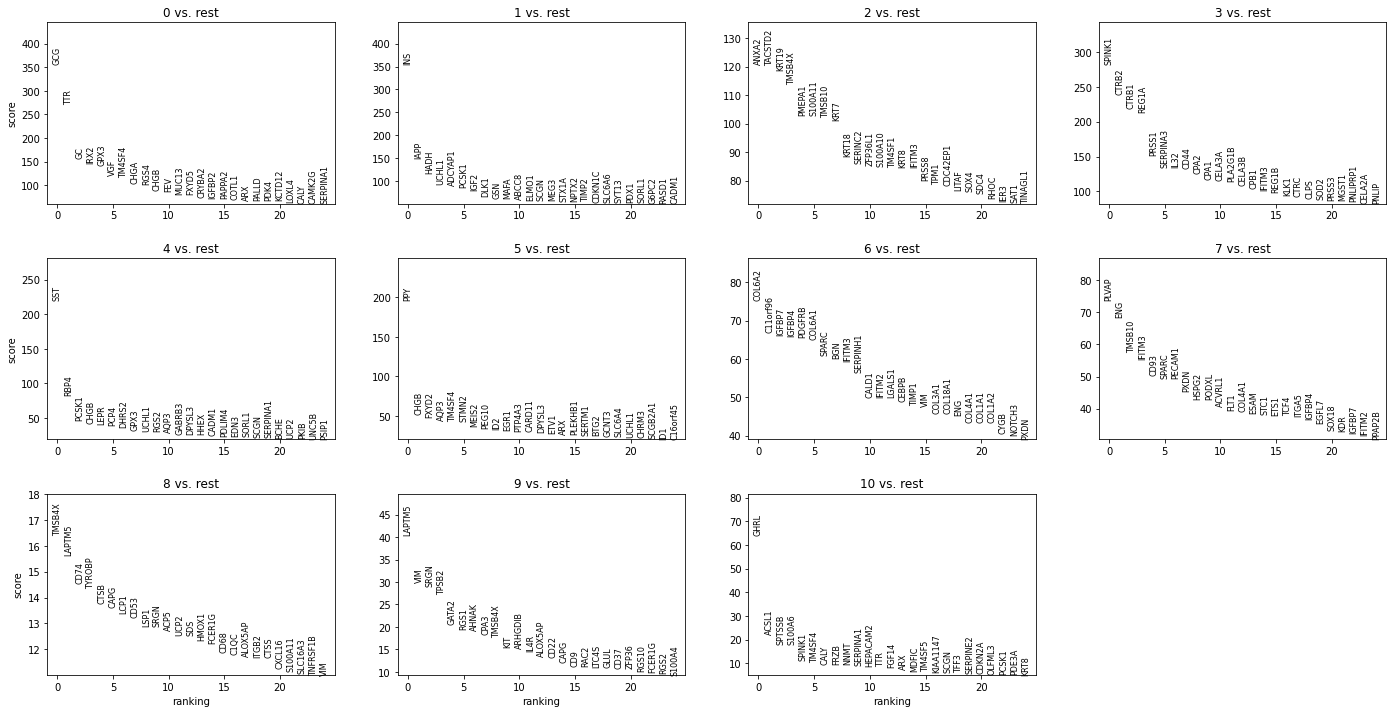

In [39]:
sc.tl.rank_genes_groups(adata_gene, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata_gene,  n_genes=25, sharey=False)